In [72]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [73]:
def str_to_list(s):
    return list(map(lambda x: x[1:-1], s[1:-1].split()))
    s =  s[1:-1]
    s = s.split()
    return [eval(x) for x in s]

def str_to_floats(s):
    s =  s[1:-1]
    s = s.split(',')
    return [eval(x) for x in s]

def str_to_float(s):
    if s == 'accurate':
        return 0.0
    elif s == 'major_inaccurate':
        return 1.0
    else:
        return 0.5

In [74]:
df = pd.read_csv('../groq/groq-hallucination.csv')
df

,gpt3_text,wiki_bio_text,gpt3_sentences,annotation,wiki_bio_test_idx,gpt3_text_samples,gpt-3.5-turbo,gpt-4o-mini,llama-3.2-3b-preview,gemma2-9b-it,mixtral-8x7b-32768,llama-3.2-3b-preview-rabbit,llama-3.2-3b-preview-rabbitX,llama-3.2-3b-preview-rabbitY,llama-3.2-3b-preview-rabbitZ,gemma2-9b-it-rabbitY,gemma2-9b-it-rabbitZ
0,John Russell Reynolds (1820–1876) was an Engli...,"Sir John Russell Reynolds, 1st Baronet (22 May...",['John Russell Reynolds (1820–1876) was an Eng...,['major_inaccurate' 'major_inaccurate' 'major_...,62464,['John Russell Reynolds (1 November 1829 – 11...,"[0.95, 0.9, 1.0, 0.75, 0.1, 0.65, 0.3, 0.65, 0...","[1.0, 1.0, 1.0, 1.0, 0.25, 0.85, 0.55, 0.9, 1.0]","[1.0, 1.0, 1.0, 1.0, 0.25, 0.9, 0.45, 0.9, 0.95]","[0.95, 0.95, 1.0, 1.0, 0.4, 0.9, 0.7, 0.95, 0.9]","[1.0, 0.9, 0.95, 0.85, 0.15, 0.6, 0.05, 0.55, ...","[1.0, 0.85, 0.75, 0.95, 0.3, 0.65, 0.05, 0.2, ...","[1.0, 1.0, 0.775, 0.85, 0.375, 0.65, 0.15, 0.4...","[0.95, 0.95, 0.65, 0.85, 0.25, 0.7, 0.1, 0.25,...","[1.0, 1.0, 1.0, 1.0, 0.65, 0.9, 0.95, 1.0, 1.0]","[0.95, 0.9, 1.0, 0.9, 0.35, 0.75, 0.2, 0.9, 0.7]","[0.9, 0.95, 1.0, 1.0, 0.35, 1.0, 0.8, 1.0, 1.0]"
1,"Matthew Aylmer, 1st Baron Aylmer (1708–1794) w...","Admiral of the Fleet Matthew Aylmer, 1st Baron...","['Matthew Aylmer, 1st Baron Aylmer (1708–1794)...",['minor_inaccurate' 'minor_inaccurate' 'minor_...,49661,"['""Matthew Aylmer, 1st Baron Aylmer (c. 1650–1...","[0.95, 0.85, 1.0, 0.95, 0.9, 0.9, 0.85]","[1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 1.0]","[1.0, 1.0, 1.0, 1.0, 1.0, 0.95, 0.95]","[0.95, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0]","[1.0, 0.75, 1.0, 0.95, 1.0, 1.0, 0.85]","[1.0, 0.9, 1.0, 0.95, 1.0, 0.8, 0.45]","[1.0, 0.9, 1.0, 0.875, 0.95, 0.675, 0.525]","[0.95, 0.9, 1.0, 0.8, 0.9, 0.7, 0.1]","[0.9, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[0.95, 0.8, 1.0, 0.95, 1.0, 0.9, 1.0]","[0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]"
2,Rick Mahler (born Richard Alan Mahler on April...,"Richard Keith Mahler (August 5, 1953 in Austin...",['Rick Mahler (born Richard Alan Mahler on Apr...,['minor_inaccurate' 'minor_inaccurate' 'accura...,20483,"['Rick Mahler (January 8, 1956 – May 25, 2005)...","[1.0, 0.3, 0.35, 0.4, 0.5, 0.65, 0.8, 0.0, 0.8]","[1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 0.35, 1.0]","[1.0, 0.75, 0.9, 0.7, 1.0, 0.95, 1.0, 0.65, 1.0]","[1.0, 1.0, 1.0, 0.65, 1.0, 1.0, 1.0, 0.45, 0.95]","[1.0, 0.8, 0.4, 0.45, 0.85, 0.7, 0.75, 0.05, 1.0]","[1.0, 0.55, 0.7, 0.55, 0.95, 0.9, 0.95, 0.3, 1.0]","[0.975, 0.55, 0.75, 0.65, 0.9, 0.875, 1.0, 0.2...","[0.9, 0.45, 0.7, 0.55, 0.9, 0.85, 1.0, 0.15, 1.0]","[1.0, 0.55, 1.0, 1.0, 1.0, 1.0, 1.0, 0.85, 1.0]","[1.0, 0.9, 0.45, 0.65, 1.0, 0.9, 0.95, 0.1, 0.8]","[1.0, 1.0, 1.0, 0.85, 1.0, 1.0, 1.0, 0.9, 0.85]"
3,James Blair (1732–1782) was an American lawyer...,"James Blair (September 26, 1786 - April 1, 183...",['James Blair (1732–1782) was an American lawy...,['minor_inaccurate' 'major_inaccurate' 'major_...,71174,"['James Blair (April 2, 1755 – March 8, 1842) ...","[1.0, 0.9, 1.0, 0.7, 0.75, 0.8, 0.95, 0.0, 0.95]","[1.0, 0.95, 1.0, 1.0, 0.9, 0.9, 1.0, 0.4, 1.0]","[1.0, 0.95, 1.0, 1.0, 0.85, 0.9, 1.0, 0.65, 1.0]","[1.0, 0.9, 1.0, 1.0, 0.9, 1.0, 1.0, 0.4, 1.0]","[1.0, 0.95, 1.0, 0.75, 0.65, 0.85, 1.0, 0.15, ...","[1.0, 0.9, 1.0, 0.9, 0.35, 0.8, 0.95, 0.1, 1.0]","[0.95, 0.9, 1.0, 0.8, 0.375, 0.9, 0.95, 0.05, ...","[0.95, 0.85, 1.0, 0.8, 0.25, 0.85, 0.9, 0.05, ...","[0.975, 0.95, 1.0, 1.0, 0.975, 0.95, 1.0, 0.67...","[0.95, 0.9, 1.0, 0.9, 0.8, 0.9, 1.0, 0.35, 1.0]","[0.9, 0.95, 1.0, 1.0, 1.0, 1.0, 1.0, 0.45, 1.0]"
4,"Tim Finchem (born August 24, 1947) is an Ameri...","Timothy W. Finchem (born April 19, 1947) is th...","['Tim Finchem (born August 24, 1947) is an Ame...",['minor_inaccurate' 'accurate' 'major_inaccura...,39945,"['""Tim Finchem (born May 27, 1953) is an Ameri...","[0.9, 0.35, 0.3, 0.6, 0.45, 0.1, 0.05, 0.0, 0....","[1.0, 0.35, 1.0, 1.0, 1.0, 0.3, 0.15, 0.1, 0.0...","[1.0, 0.3, 1.0, 1.0, 1.0, 0.6, 0.45, 0.4, 0.1,...","[1.0, 0.35, 1.0, 1.0, 0.95, 0.75, 0.2, 0.15, 0...","[1.0, 0.25, 0.2, 0.45, 0.5,

# AUC-PR

In [75]:
def plot_auc_pr(models, results, label, title):
    plt.figure(figsize=(8, 8)) 
    for model in models:
        precision, recall, auc_pr = results[model][label]
        sns.lineplot(x=recall, y=precision, label=f'{model} (AUC-PR={auc_pr:.2f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

In [77]:
def calculate_auc_pr(model, labels):
    results = {}
    TRUTH = {label: [] for label in labels}
    PRED = {label: [] for label in labels}
    for annotation, prediction in zip(df['annotation'], df[model]):
        annotation = str_to_list(annotation)
        label = np.array([str_to_float(x) for x in annotation])
        prediction = str_to_floats(prediction)
        assert len(label) == len(prediction)

        human_label_detect_false = (label > 0.499).astype(np.int32).tolist()
        human_label_detect_true = (label < 0.499).astype(np.int32).tolist()
        if np.mean(label) < 0.99:
            human_label_detect_false_h = (label > 0.99).astype(np.int32).tolist()
        
        TRUTH['accurate'].extend(human_label_detect_true)
        PRED['accurate'].extend([1.0-x for x in prediction])

        TRUTH['major_inaccurate'].extend(human_label_detect_false)
        PRED['major_inaccurate'].extend(prediction)

        if np.mean(label) < 0.99:
            TRUTH['minor_inaccurate'].extend(human_label_detect_false_h)
            PRED['minor_inaccurate'].extend(prediction)
        
    for l in labels:
        precision, recall, _ = precision_recall_curve(TRUTH[l], PRED[l])
        auc_pr = auc(recall, precision)
        results[l] = (precision, recall, auc_pr)
    return results

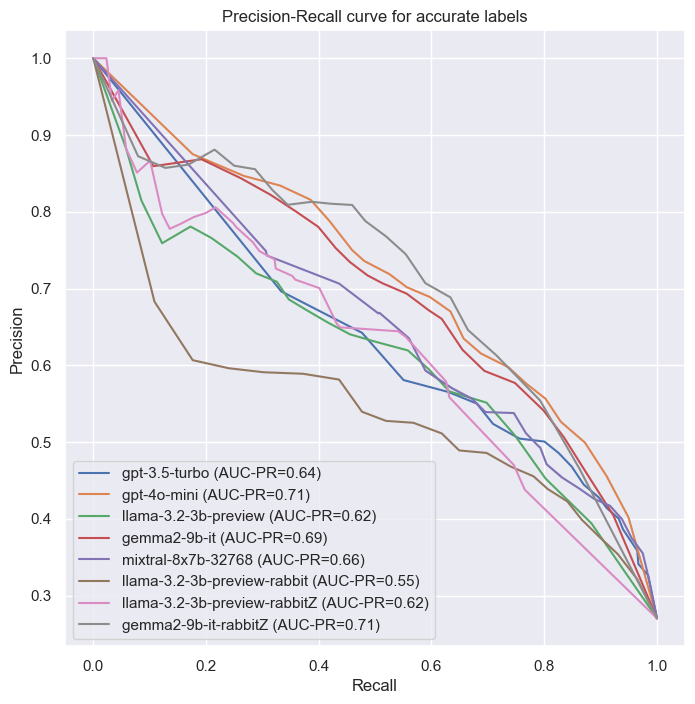

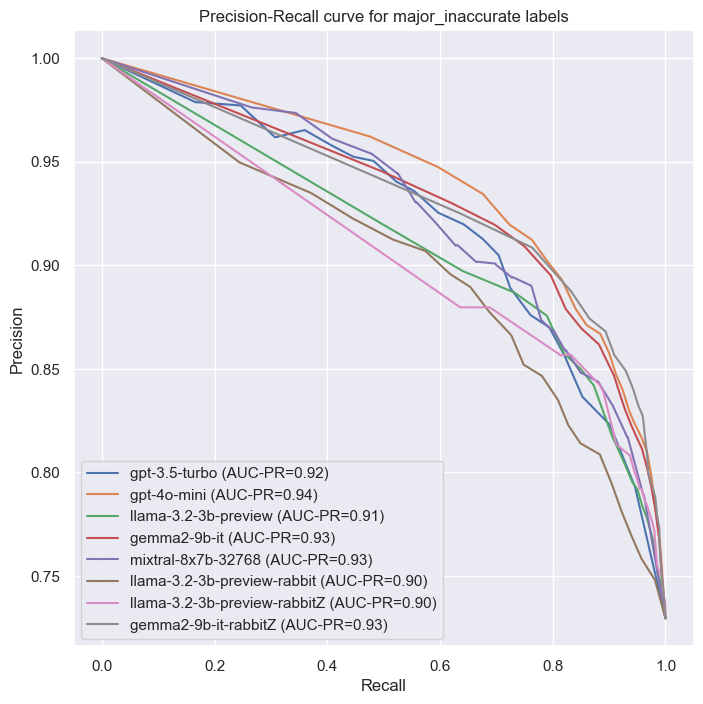

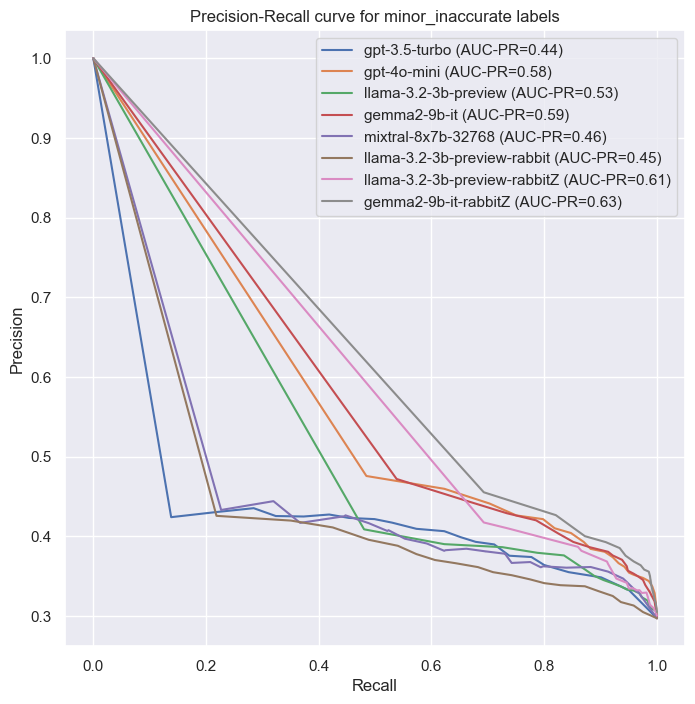

In [78]:
models = ['gpt-3.5-turbo', 'gpt-4o-mini', 'llama-3.2-3b-preview', 'gemma2-9b-it', 'mixtral-8x7b-32768', 'llama-3.2-3b-preview-rabbit', 'llama-3.2-3b-preview-rabbitZ', 'gemma2-9b-it-rabbitZ']
labels = ['accurate', 'major_inaccurate', 'minor_inaccurate']
results = {model: {label: None for label in labels} for model in models}

# Calculate AUC-PR
for model in models:
    results[model] = calculate_auc_pr(model, labels)

# Plot AUC-PR
for label in labels:
    plot_auc_pr(models, results, label, f'Precision-Recall curve for {label} labels')